In [2]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from math import sqrt as sqrt
from math import exp as exponent
from math import log as ln

from typing import List
from typing import Tuple

#%matplotlib inline


# Куча кода на numpy

In [3]:
def generate_random_noise(delta, n_dimensions):
    low = -1
    high = 1
    random_vector = np.random.uniform(low=low, high=high, size=n_dimensions)
    
    resize_coefficient = delta / np.linalg.norm(random_vector)
    
    random_vector *= resize_coefficient
    
    return random_vector


In [4]:
class opt_func:
    
    def __init__(self, L : float = 1, mu : float = 0):
        
        '''
            f : R^n -> R
            L - Lipsitz
            mu - stongly convexity
        '''
        
        assert L >= mu, 'L < mu !!'
        
        self.L = L
        self.mu = mu
        
    
    def get_chi(self) -> float:
        return self.L / self.mu
    
    # to All functions should have these methods
        
    # def __call__(x) -> float:
    # def grad(x) -> np.array()
    # min_point(dim : int) -> np.array(dim)
    

In [5]:
class nesterov_degenerate_func(opt_func):
    
    # strongly convex
    # https://arxiv.org/pdf/1711.00394.pdf
    # page 37 - 38
    
    def __call__(self, x) -> float:
        
        assert self.mu == 0, r'$mu == 0$ !!!!  ' + r'$mu = ' + str(self.mu)
        
        dim = x.shape[0]
        
        k = (dim - 1) // 2

        answer = x[0] ** 2
        
        for i in range(2 * k):
            answer += (x[i] - x[i + 1]) ** 2
  
        answer += x[2 * k] ** 2
        answer *= (self.L / 8)

        answer -= self.L / 4 * x[0]

        return answer
        
    
    def gradient(self, x):
        
        L = self.L

        dim = x.shape[0]

        k = (dim - 1) // 2

        gradient_answer = np.zeros(dim)

        for i in range(2 * k + 1):
            if i == 0:
                gradient_answer[0] = 2 * x[0] - x[1] - 1
            elif i != (2 * k):
                gradient_answer[i ]=  2 * x[i] - x[i - 1] - x[i + 1]
            else:
                gradient_answer[i] = 2 * x[i] - x[i - 1]
    
        gradient_answer = (L / 4) * gradient_answer 

        return gradient_answer
    

    def min_point(self, dim : int):
        
        k = (dim - 1) // 2

        min_point = np.zeros(dim)

        for i in range(2 * k + 2):
            min_point[i] = 1 - (i / (2 * k + 2))
  
        return min_point

    
    def min_value(self, dim) -> float:
        return self(self.min_point(dim))
        
    

In [6]:
class nesterov_func(opt_func):
    
    # strongly convex
    # https://arxiv.org/pdf/1711.00394.pdf
    # page 37 - 38
    
    def __call__(self, x) -> float:
        
        assert self.mu > 0, r'$mu <= 0$ !!!!'
        
        x = np.array(x)
        dim = x.shape[0]
        chi = self.get_chi()
        result = 0
        
        for i in range(dim - 1):
            result += (x[i] - x[i + 1]) ** 2
        
        result += x[0] ** 2 - 2 * x[0]
        result *= self.mu * (chi - 1) / 8
        
        norm = np.linalg.norm(x)
        
        result += self.mu / 2 * (norm ** 2)
        
        return result
    
    
    def gradient(self, x):
        
        argument_x = np.array(x)
        chi = self.get_chi()
        n_dimension = argument_x.shape[0]
        
        coeficient = self.mu * (chi - 1) / 8

        grad = np.zeros(n_dimension)

        for i in range(n_dimension):

            if i == 0:
                grad[i] = 2 * (2 * argument_x[i] - argument_x[i + 1] - 1)
            elif i != n_dimension - 1:
                grad[i] = 2 * (2 * argument_x[i] - argument_x[i - 1] - argument_x[i + 1])
            else:
                grad[i] = 2 * (argument_x[i] - argument_x[i - 1])


        norm_grad = self.mu * argument_x
        grad = coeficient * grad + norm_grad

        return grad
    

    def min_point(self, dim : int):
        
        chi = self.get_chi()
        
        answer = np.zeros(dim)
        q = 4 / (chi - 1)
        
        A = np.zeros((dim, dim))
        ind = np.zeros((dim, dim))
        b = np.zeros(dim)
        b[0] = 1

        for i in range(dim):
            j = i - 1
            k = i + 1
            if j >= 0:
                A[i][j] = -1
            if k < dim:
                A[i][k] = -1
            A[i][i] = 2
            ind[i][i] = 1
        
        A[dim - 1][dim - 1] = 1

        Matrix = A + q * ind
        
        optimal_x = np.linalg.solve(Matrix, b)
        return optimal_x

    
    def min_value(self, dim) -> float:
        return self(self.min_point(dim))
        
    

In [7]:
def get_gradient_noise(gradient_function, point, delta):
    noise = generate_random_noise(delta, point.shape[0])
    answer = gradient_function(point) + noise
    
    return answer


def add_noise(gradient, delta : float, dim : int):
    noise = generate_random_noise(delta, dim)
    return noise + gradient


In [8]:
def calculate_alpha_sequence(A_prev, alpha_prev, L, mu):
    
    Am = 1 + A_prev * mu
    
    alpha = Am / 2 / L + sqrt(Am / 4 / (L ** 2) + A_prev * Am / L)
    
    return alpha
    

In [293]:
def stm_algo(function_opt, iters = 1000, x_start = np.zeros(100), dim = -1, delta : float = 0, alpha : float = 0, make_boost_step : bool = False):

    '''
        https://arxiv.org/pdf/2102.02921.pdf
        page 15
        
        function_opt - inherited from opt_func
        delta - for addititve noise
        alpha - for relative noise
        make_boost_step - extra gradient step in the end of each iteration to make gradient smaller
        
        
        Don't mix additive and relative noise
        
    '''
    
    assert delta * alpha == 0, 'Dont mix additive and relative noise !!'
    
    if dim < 0:
        n_dim = x_start.shape[0]
    else:
        n_dim = dim
        x_start = np.zeros(n_dim)
    
    alpha_prev = 0
    A_prev = 0
    
    # main sequences
    # y - for tilde x_k
    
    y_prev = x_start
    z_prev = x_start
    x_prev = x_start

    path = [(y_prev, z_prev, x_prev)]  

    m_2 = function_opt.mu / 2
    L = 2 * function_opt.L
    
    for k in range(iters):
        
        alpha_prev = calculate_alpha_sequence(A_prev, alpha_prev, L, m_2)
        A_current = A_prev + alpha_prev

        y_current = (A_prev * x_prev + alpha_prev * z_prev) / A_current
        
        true_gradient = function_opt.gradient(y_current)
        relative_noise = alpha * np.linalg.norm(true_gradient)
        
        gradient_y = add_noise(true_gradient, delta + relative_noise, n_dim)
        
        vector_step = alpha_prev / (1 + m_2 * A_current) * (gradient_y + m_2 * (z_prev - y_current))
        
        z_current = z_prev - vector_step
        
        x_current = (A_prev * x_prev + alpha_prev * z_current) / A_current
        
        if make_boost_step:
            # BOOST STEP
            d_x = alpha * np.linalg.norm(function_opt.gradient(x_current))
            gradient_x = add_noise(function_opt.gradient(x_current), x_current, delta + d_x)
            x_current = x_current - 1 / L * gradient_x 

        A_prev, y_prev, z_prev, x_prev = A_current, y_current, z_current, x_current
        
        path.append((y_prev, z_prev, x_prev))
        
    return path


In [10]:
def adaptive_fast(function_opt, iters = 1000, x_start = np.zeros(100), dim = -1, delta : float = 0, alpha : float = 0, make_boost_step : bool = False):
    
    '''
        https://arxiv.org/pdf/2001.09013.pdf
        page 15
        
        function_opt - inherited from opt_func
        delta - for addititve noise
        alpha - for relative noise
        
        Don't mix additive and relative noise
    '''
    
    assert delta * alpha == 0, 'Dont mix additive and relative noise !!'
    
    if dim < 0:
        n_dim = x_start.shape[0]
    else:
        n_dim = dim
        x_start = np.zeros(n_dim)
    
    alpha_prev = 0
    A_prev = 0
    
    y_prev = x_start
    z_prev = x_start
    x_prev = x_start
    
    path = [(y_prev, z_prev, x_prev)]  
    
    m_2 = function_opt.mu / 2
    
    for k in range(iters):
        
        alpha_prev = calculate_alpha_sequence(A_prev, alpha_prev, function_opt.L, m_2)
        A_current = A_prev + alpha_prev

        y_current = (A_prev * x_prev + alpha_prev * z_prev) / A_current
        
        true_gradient = function_opt.gradient(y_current)
        relative_noise = alpha * np.linalg.norm(true_gradient)
        
        gradient_y = add_noise(true_gradient, delta + relative_noise, n_dim)
        
        vector_step = (m_2 * alpha_prev * y_current - gradient_y * alpha_prev) / (1 + m_2 * A_current)
        mult_coef = (1 + m_2 * A_prev) / (1 + m_2 * A_current)
        z_current = mult_coef * z_prev + vector_step
        
        x_current = (A_prev * x_prev + alpha_prev * z_current) / A_current
        
        A_prev, y_prev, z_prev, x_prev = A_current, y_current, z_current, x_current
        
        path.append((y_prev, z_prev, x_prev))
    
    return path
    

In [40]:
def algo_triple_momentum(function_opt, iters : int = 1000, x_start = np.zeros(100), dim = -1, delta : float = 0, alpha : float = 0,
                         make_boost_step : bool = False):
    
    '''
        https://link.springer.com/content/pdf/10.1007/s10107-021-01665-8.pdf
        page 9
        
        function_opt - inherited from opt_func
        delta - for addititve noise
        alpha - for relative noise
        
        Don't mix additive and relative noise
    '''
    
    assert delta * alpha == 0, 'Dont mix additive and relative noise !!'
    
    if dim < 0:
        n_dim = x_start.shape[0]
    else:
        n_dim = dim
        x_start = np.zeros(n_dim)
    
    
    path = [(x_start, x_start)]
    
    xi_prev_prev = np.zeros(n_dim)
    xi_prev = x_start
    y_prev = x_start
    
    L = function_opt.L
    mu = function_opt.mu
    
    chi = function_opt.L / function_opt.mu
    rho = 1 - 1 / np.sqrt(chi)
    a = (1 + rho) / L
    beta = rho * rho / (2 - rho)
    gamma = rho * rho / ((1 + rho) * (2 - rho))
    
    for k in range(iters):
        
        true_gradient = function_opt.gradient(y_prev)
        relative_noise = alpha * np.linalg.norm(true_gradient)
        gradient_y = add_noise(true_gradient, delta + relative_noise, n_dim)
        xi_cur = xi_prev + beta * (xi_prev - xi_prev_prev) - a * gradient_y
        y_cur = xi_cur + gamma * (xi_cur - xi_prev)
        
        path.append((xi_cur, y_cur))
        
        xi_prev_prev, xi_prev, y_prev = xi_prev, xi_cur, y_cur
    
    return path
        

In [11]:
def grad_desc(function_opt, iters=1000):
    
    n_dim = 1000
    
    x_start = np.ones(n_dim) * 10000
    alpha = 0.95
    
    x_cur = x_start
    
    path = [x_start]
    
    min_val = function_opt.min_value(n_dim)
    for i in range(iters):
        
        true_gradient = function_opt.gradient(x_cur)
        relative_noise = alpha * np.linalg.norm(true_gradient)
        step = add_noise(true_gradient, relative_noise, n_dim)
        
        x_cur = x_cur - 1 / function_opt.L * step
    
        path.append(x_cur)
    
    min_val = function_opt.min_value(n_dim)
    
    diff = [function_opt(x) - min_val for x in path]
    
    x_cur = x_start
    
    path_2 = [x_start]
    
    for i in range(iters):
        
        true_gradient = function_opt.gradient(x_cur)
        step = true_gradient
        x_cur = x_cur - 1 / function_opt.L * step
        path_2.append(x_cur)
   
    diff_2 = [function_opt(x) - min_val for x in path_2]
      
    L = function_opt.L
    m = function_opt.mu
    
    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        
        plt.figure(figsize=(16, 9), dpi=120, facecolor='whitesmoke')
        
        plt.semilogy(range(iters + 1), diff, color='salmon', alpha=1, label='with noise')
        plt.semilogy(range(iters + 1), diff_2, color='royalblue', alpha=1, label='no noise')
        
        
        plt.xlabel('Iterations - N', fontsize=15)
        plt.ylabel(r'Function residual - $f(x) - f^*$', fontsize=15)
        plt.title('Gradient descent with relative noise ' + r'L = {}, $\mu$ = {}, $\alpha$ = {}'.format(L, m, alpha), fontsize=15)
        
        
    

In [12]:
def calculate_alpha_sequence(A_prev, alpha_prev, L, mu):
    
    Am = 1 + A_prev * mu
    
    alpha = Am / 2 / L + sqrt(Am / 4 / (L ** 2) + A_prev * Am / L)
    
    return alpha


def print_parts(N, L, mu):
    
    alpha_ = 0
    A_ = 0 
    
    for k in range(N):
        
        alpha_ = calculate_alpha_sequence(A_, alpha_, L, mu)
        
        if A_ > 0:
            print(round(alpha_ / A_, 4))
            
        A_ = alpha_ + A_    


# Дальше смотрим графики

### Сходимость градиентного спуска

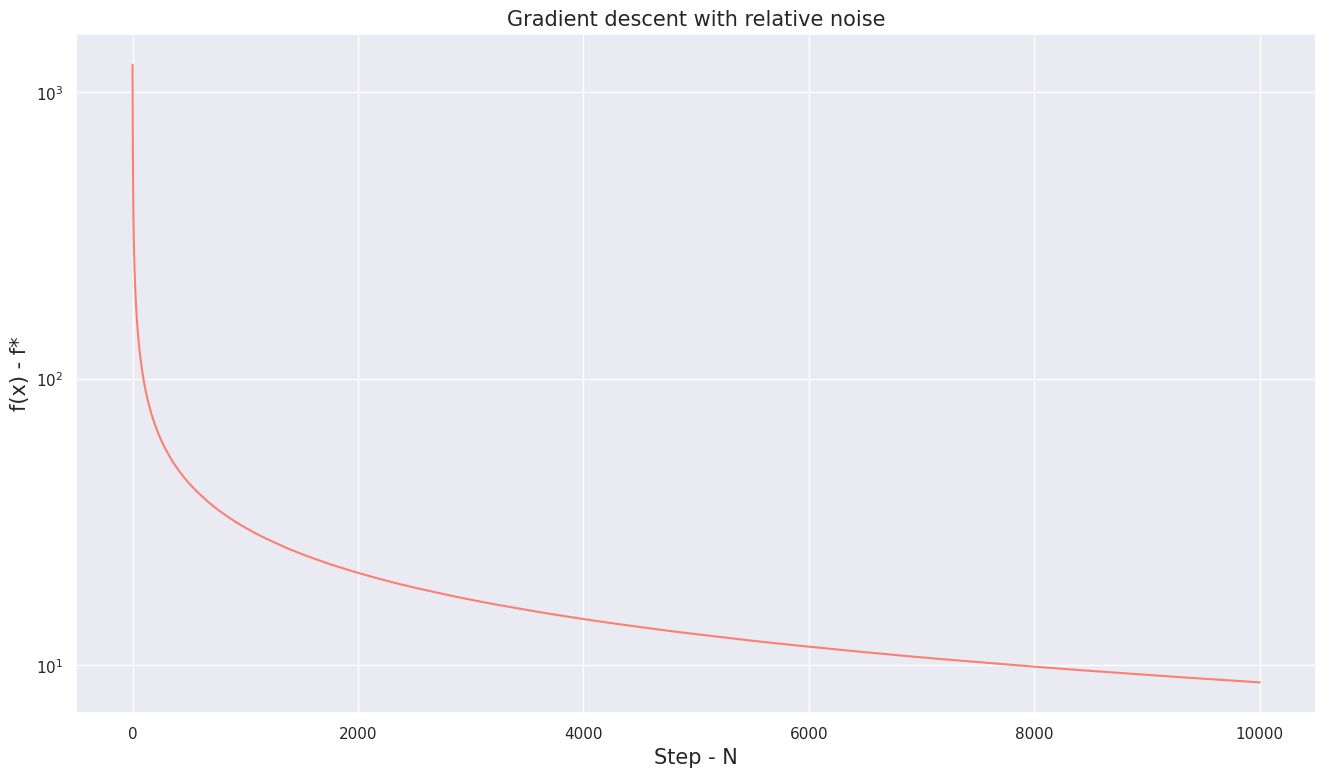

In [68]:
grad_desc(nesterov_degenerate_func(L=10000), iters=10000)

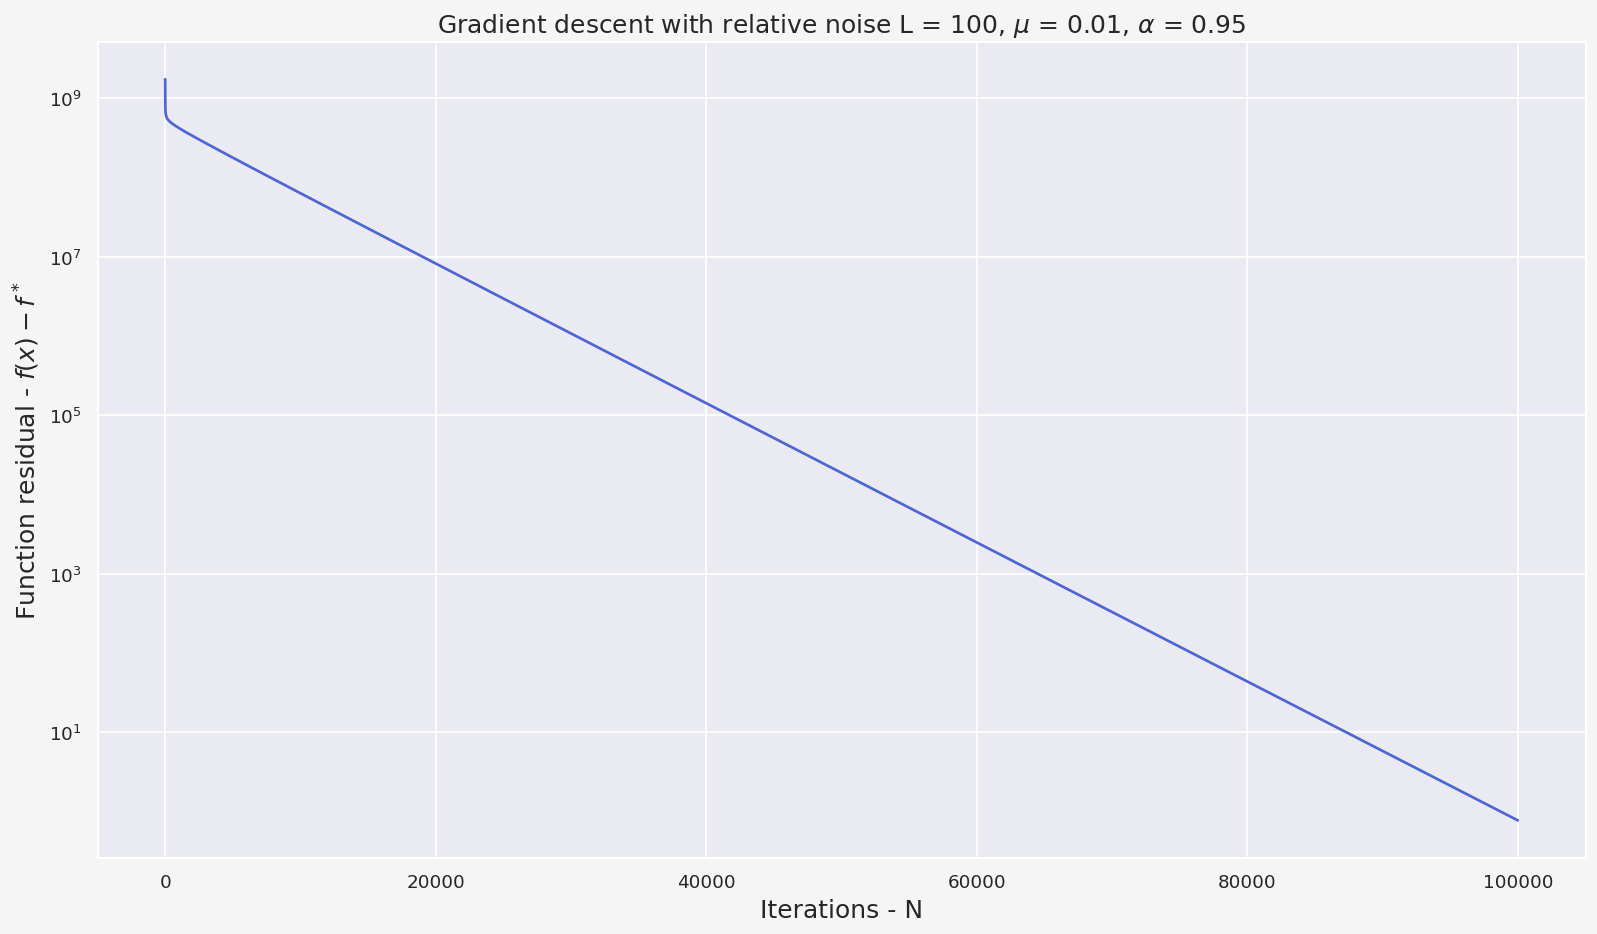

In [211]:
grad_desc(nesterov_func(L=100, mu=0.01), iters=100000)

In [22]:
def get_residuals(function_opt, path):
    dim = path[0][0].shape[0]
    min_value = function_opt.min_value(dim)
    return [function_opt(x) - min_value for x in path]


def helper_residuals_multy(func, points : Tuple, min_value : float) -> Tuple:
    return tuple([func(point) - min_value for point in points])


def get_residuals_stm_path(function_opt, path):
    dim = path[0][0].shape[0]
    min_value = function_opt.min_value(dim)
    return [helper_residuals_multy(function_opt, points, min_value) for points in path]
    
        

In [23]:
def plot_convergence(function_opt, algo, iters : int = 1000, x_start = np.zeros(1), dim : int = -1, delta : float = 0, alpha : float = 0,
                         make_boost_step : bool = False, addition_title : str = ''):
    
    mu = function_opt.mu
    L = function_opt.L
    
    path_stm = algo(function_opt, x_start=x_start, dim=dim, delta=delta, alpha=alpha, iters=iters, make_boost_step=make_boost_step)
    diff = get_residuals_stm_path(function_opt, path_stm)
      
    names = [r'y', r'z', r'x']
    colors = ['green', 'red', 'salmon']
    
    # diff_tilde = [x[2] - x[0] for x in diff]
    
    with sns.plotting_context('notebook'), sns.axes_style("darkgrid"):
        
        plt.figure(figsize=(16, 9), dpi=120, facecolor='whitesmoke')
        
        for i in range(len(diff[0])):
            
            deltas = [d[i] for d in diff]
            ticks = range(0, iters + 1)
            
            name = names[i]
            color = colors[i]
            
            plt.semilogy(ticks, deltas, color=color, alpha=0.5, label='Residuals for ' + name + ' sequence')
        
        # plt.semilogy(ticks, diff_tilde, color='black', alpha=1, label='f(x`) - f(x)')
        
        plt.xlabel('Iterations - N', fontsize=15)
        plt.ylabel(r'Function residual - $f(x) - f^*$', fontsize=15)
        plt.legend(loc='best', fontsize=10)
        plt.title((r'L = {}, $\mu = ${}, $\alpha$ = {}, $\delta$ = {} ' + addition_title).format(L, mu, alpha, delta), fontsize=15)
        plt.show()
    
    
    

In [24]:
def stm_tilde_dif(function_opt, iters : int = 1000, x_start = np.zeros(1), dim : int = -1, delta : float = 0, alpha : float = 0,
                         make_boost_step : bool = False, algo = None):
    mu = function_opt.mu
    L = function_opt.L
    
    path_stm = algo(function_opt, x_start=x_start, dim=dim, delta=delta, alpha=alpha, iters=iters, make_boost_step=make_boost_step)
    diff = get_residuals_stm_path(function_opt, path_stm)
    
    diff_tilde = [x[0] - x[2] for x in diff]
    
    with sns.plotting_context('notebook'), sns.axes_style("darkgrid"):
        
        plt.figure(figsize=(16, 9), dpi=120)
        ticks = range(0, iters + 1)
        plt.semilogy(ticks, diff_tilde, color='salmon', alpha=1)
        
        plt.ylabel(r'f(x`) - f(x)', fontsize=15)
        plt.xlabel('Iteration - N', fontsize=15)
        
        plt.show()
    
        

In [25]:
def plot_for_diff_alpha(function_opt, iters : int = 1000, x_start = np.zeros(1), dim : int = -1, alphas : List[float] = 0,
                         make_boost_step : bool = False, algo = None, add_text : str = ''):
    
    mu = function_opt.mu
    L = function_opt.L
    
    paths = [algo(function_opt, x_start=x_start, dim=dim, delta=0, alpha=alpha, iters=iters, make_boost_step=make_boost_step) for alpha in alphas]
    diff = [get_residuals_stm_path(function_opt, path) for path in paths]
    
    colors = ['red', 'blue', 'green', 'pink']
    
    for dif in diff:
        for x in dif:
            x = x[2]
    
    
    dif_x = [[x[2] for x in dif] for dif in diff]
    
    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        
        plt.figure(figsize=(16, 9), dpi=120, facecolor='whitesmoke')
        ticks = range(0, iters + 1)
        
        for i, alpha in enumerate(alphas):
            
            color = colors[i]
            plt.semilogy(ticks, dif_x[i], color=color, alpha=0.5, label=r'$\alpha = ${}'.format(alpha))
        
        plt.xlabel('Iterations - N', fontsize=15)
        plt.ylabel(r'Function residual - $f(x) - f^*$', fontsize=15)
        plt.legend(loc='best', fontsize=10)
        plt.title((r'L = {}, $\mu = ${} ' + add_text).format(L, mu), fontsize=15)
        plt.show()
    
    

### Сравнение tripple momentum(https://link.springer.com/content/pdf/10.1007/s10107-021-01665-8.pdf)

### И STM(https://arxiv.org/pdf/2102.02921.pdf)

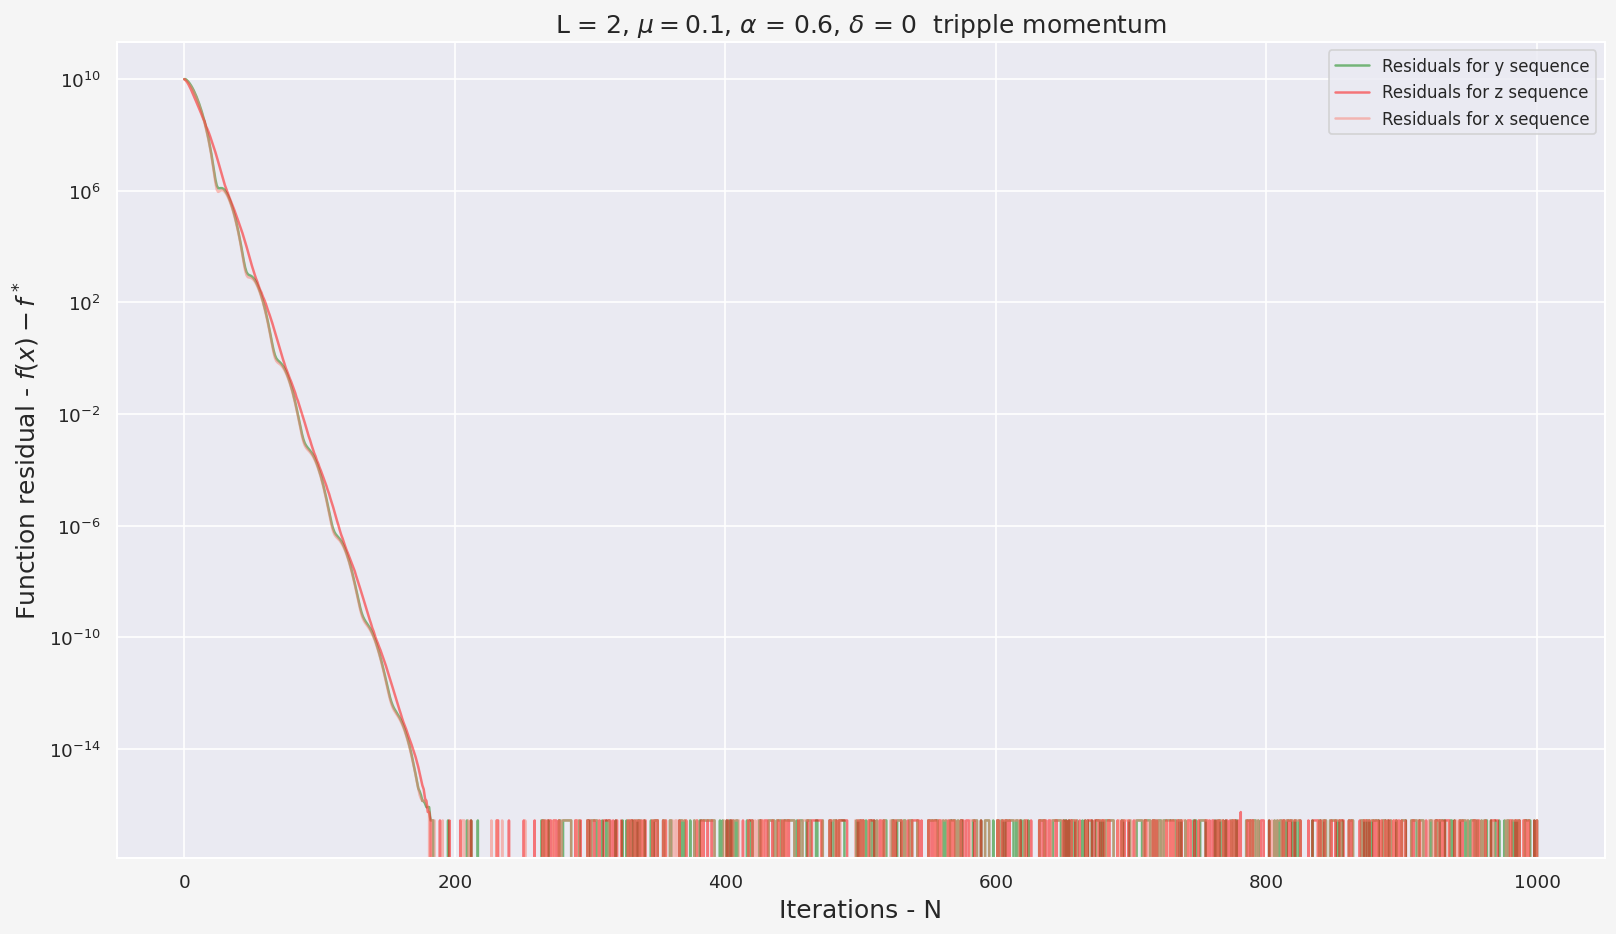

In [200]:
function = nesterov_func(2, 0.1)
plot_convergence(function, iters=1000, x_start=np.ones(2000) * 10000, alpha=0.6, algo=stm_algo, addition_title=' tripple momentum')

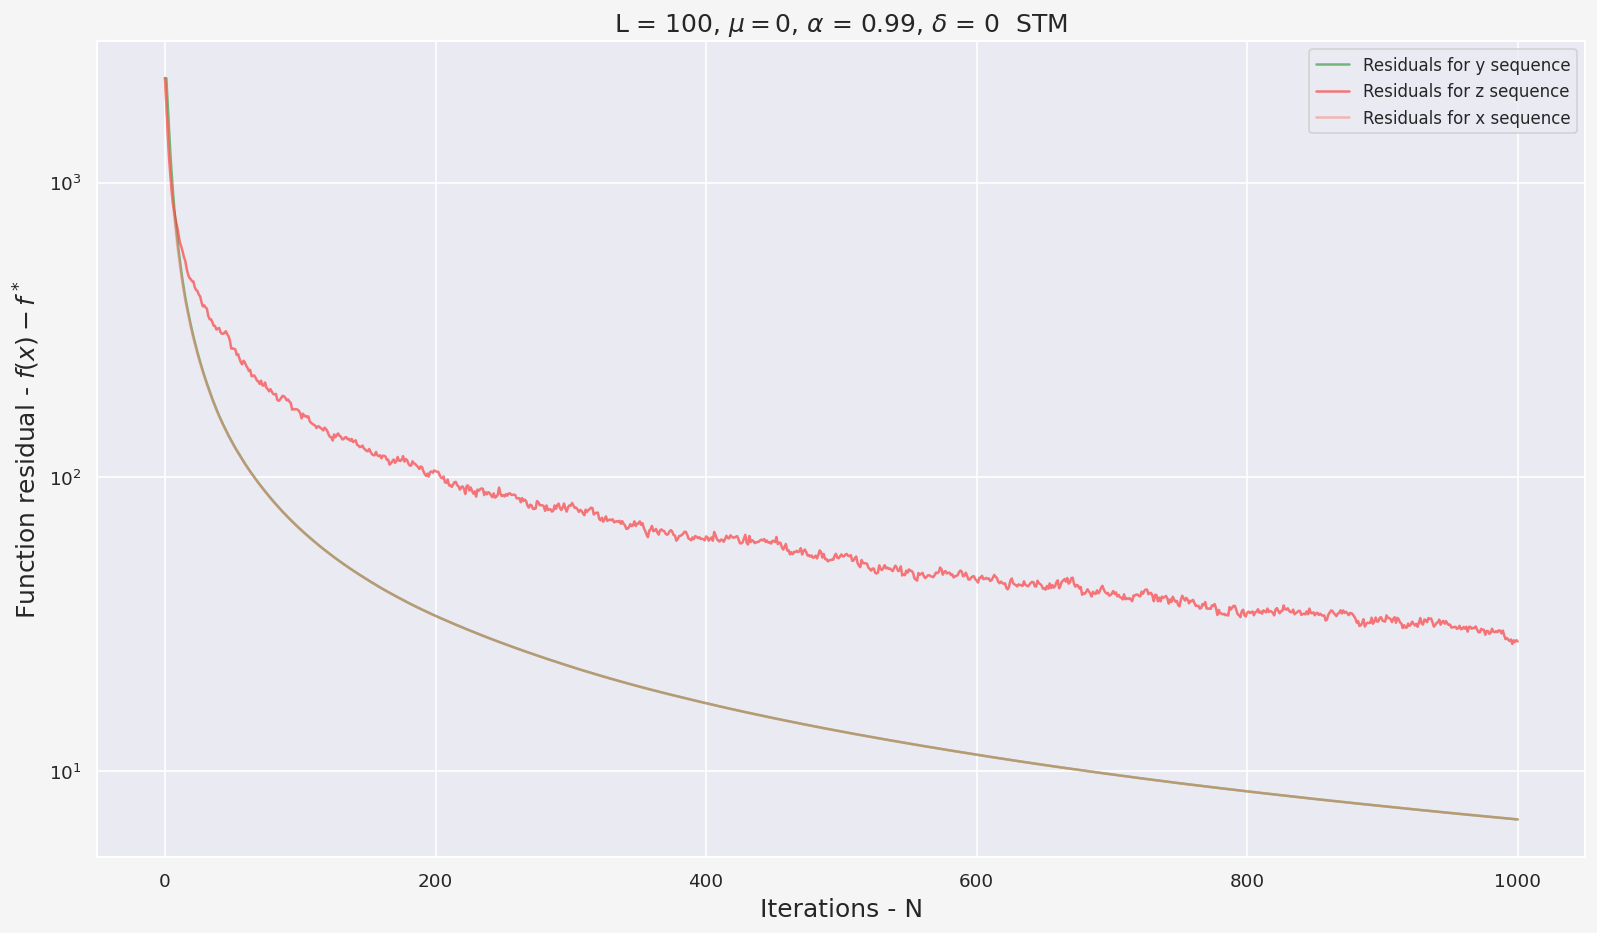

In [306]:
function = nesterov_degenerate_func(L=100)
plot_convergence(function, stm_algo, iters=1000, x_start=np.ones(2000) * 10, alpha=0.99, addition_title=' STM')

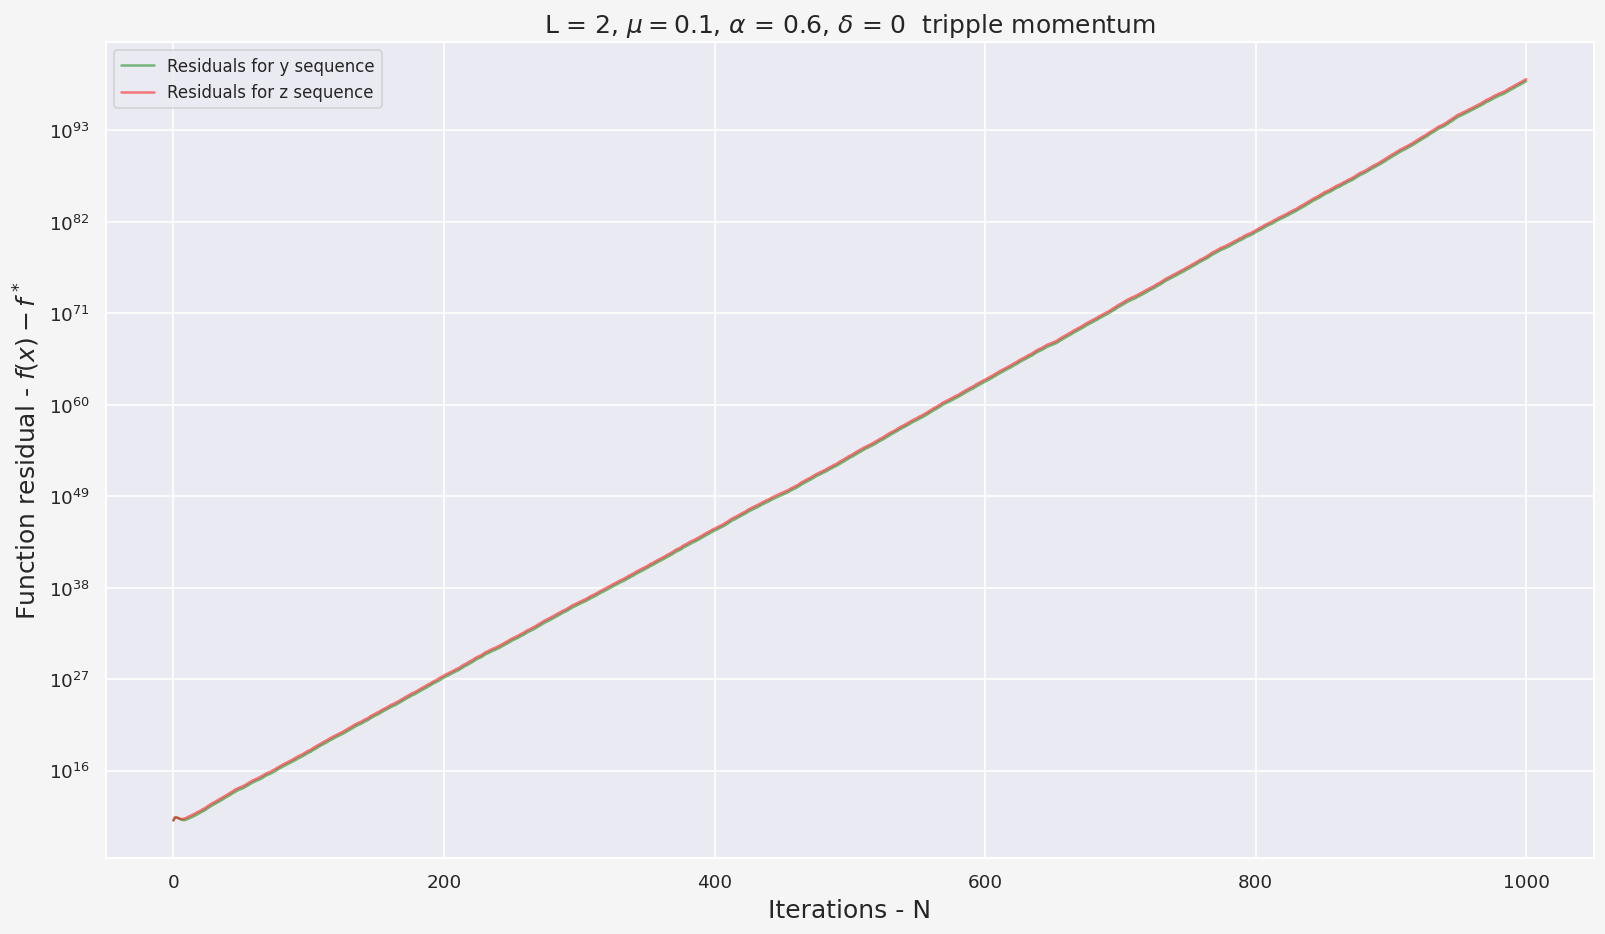

In [199]:
function = nesterov_func(2, 0.1)
plot_convergence(function, iters=1000, x_start=np.ones(2000) * 10000, alpha=0.6, algo=algo_triple_momentum, addition_title=' tripple momentum')

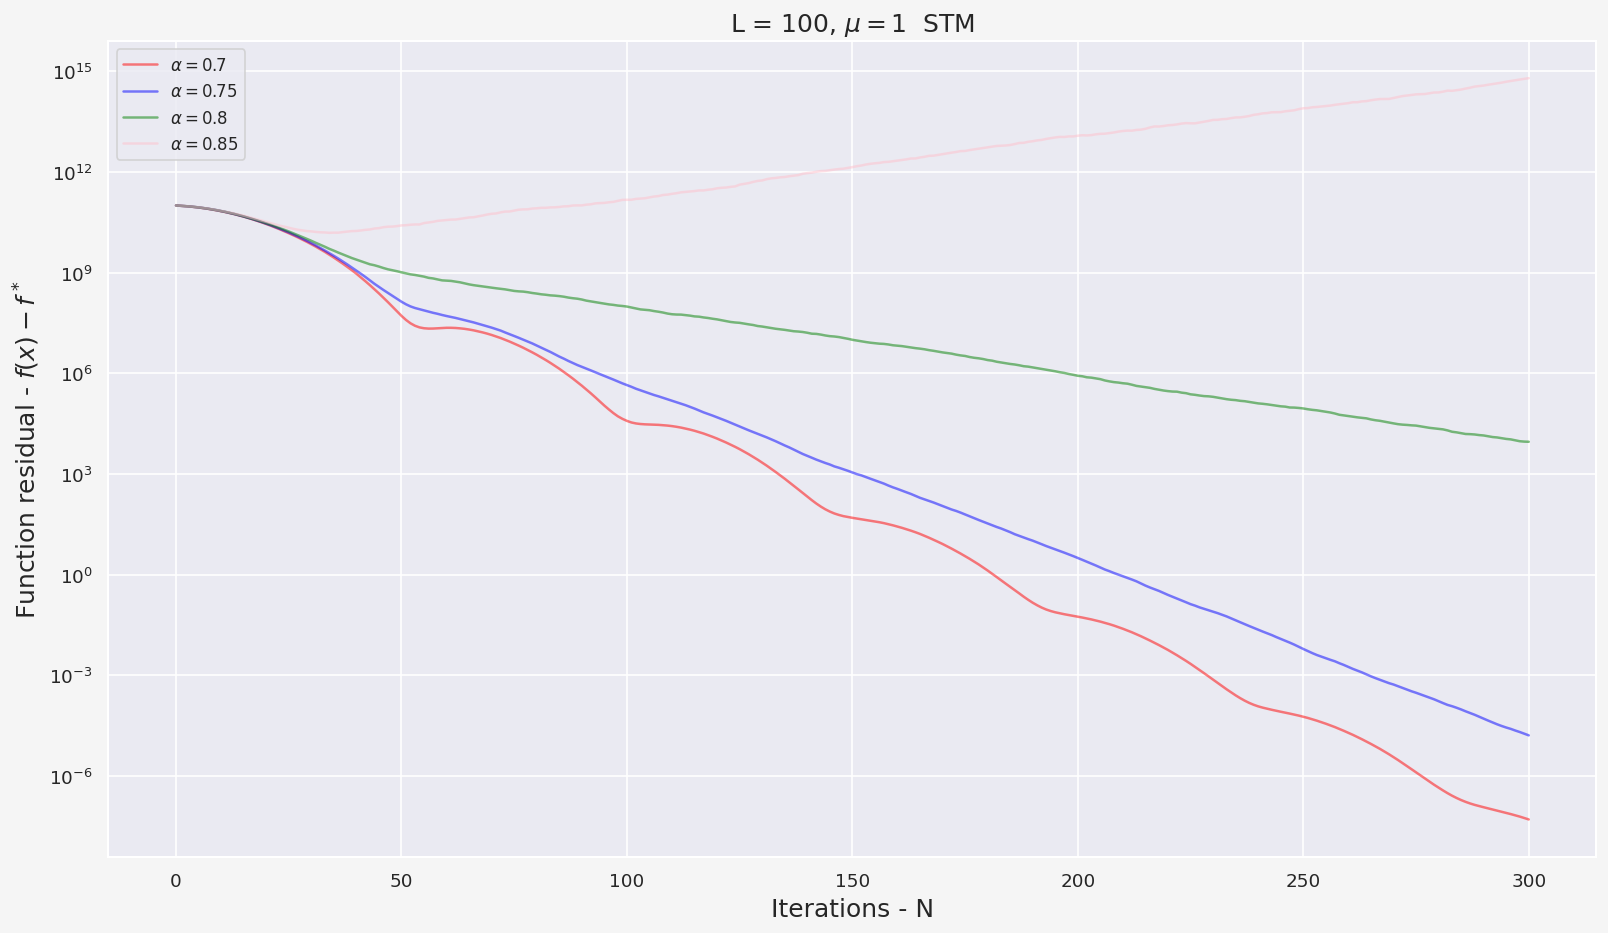

In [180]:
function = nesterov_func(100, 1)
plot_for_diff_alpha(function, iters=300, x_start=np.ones(2000) * 10000, alphas=[0.7, 0.75, 0.8, 0.85], algo=stm_algo, add_text=' STM')

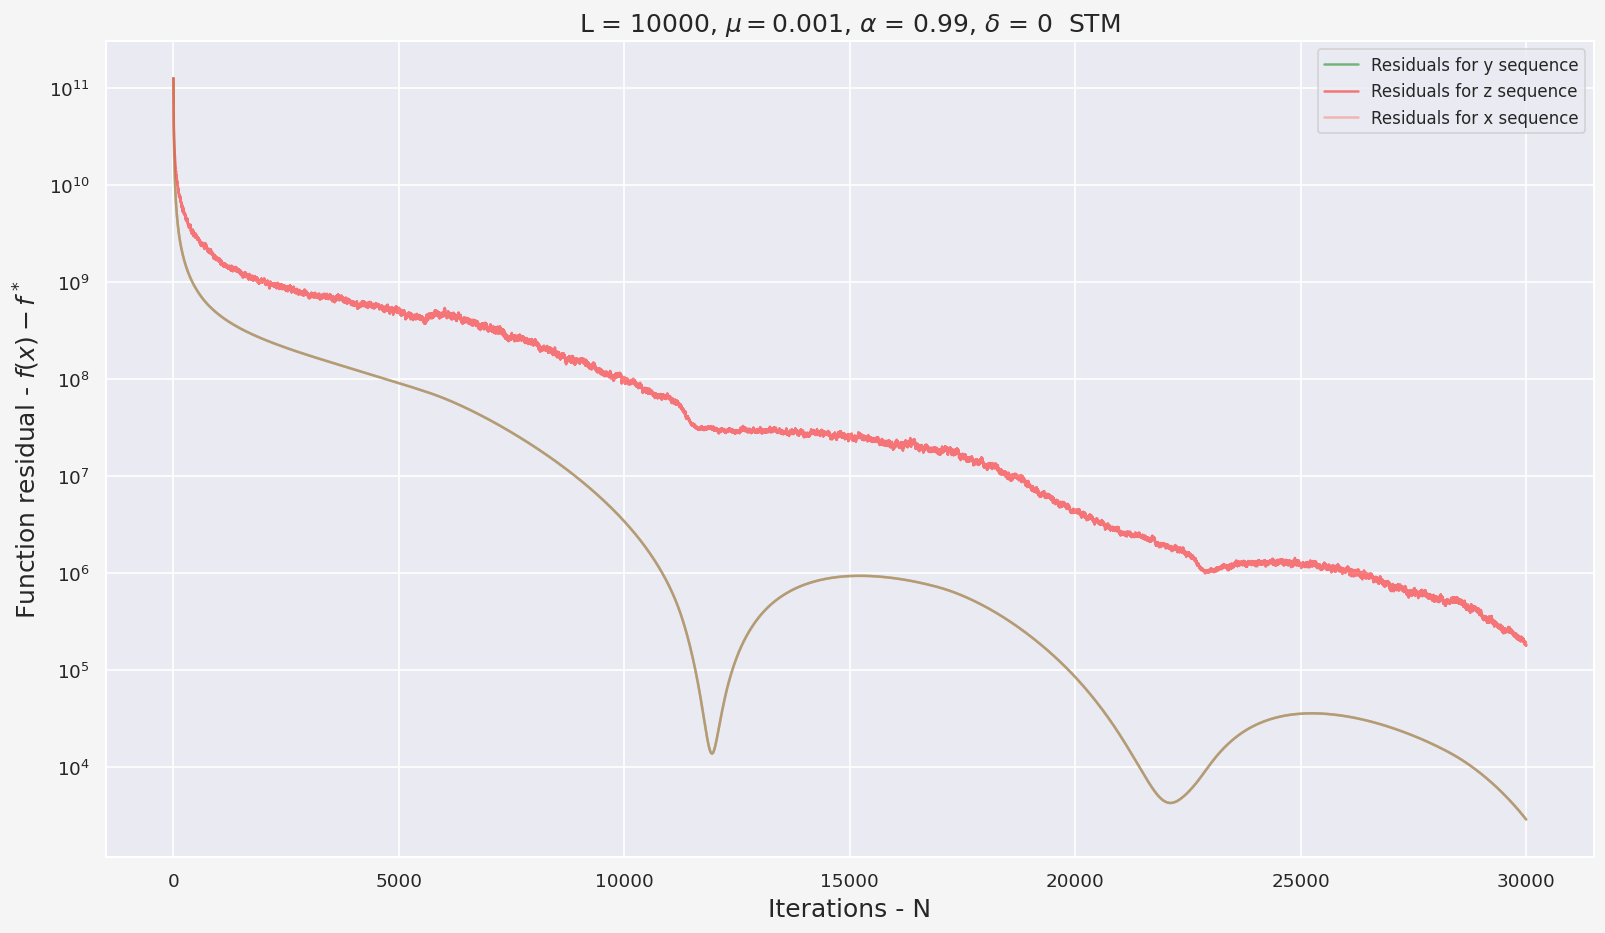

In [311]:
function = nesterov_func(10000, 0.001)
plot_convergence(function, stm_algo, iters=30000, x_start=np.ones(2000) * 10000, alpha=0.99, addition_title=' STM')

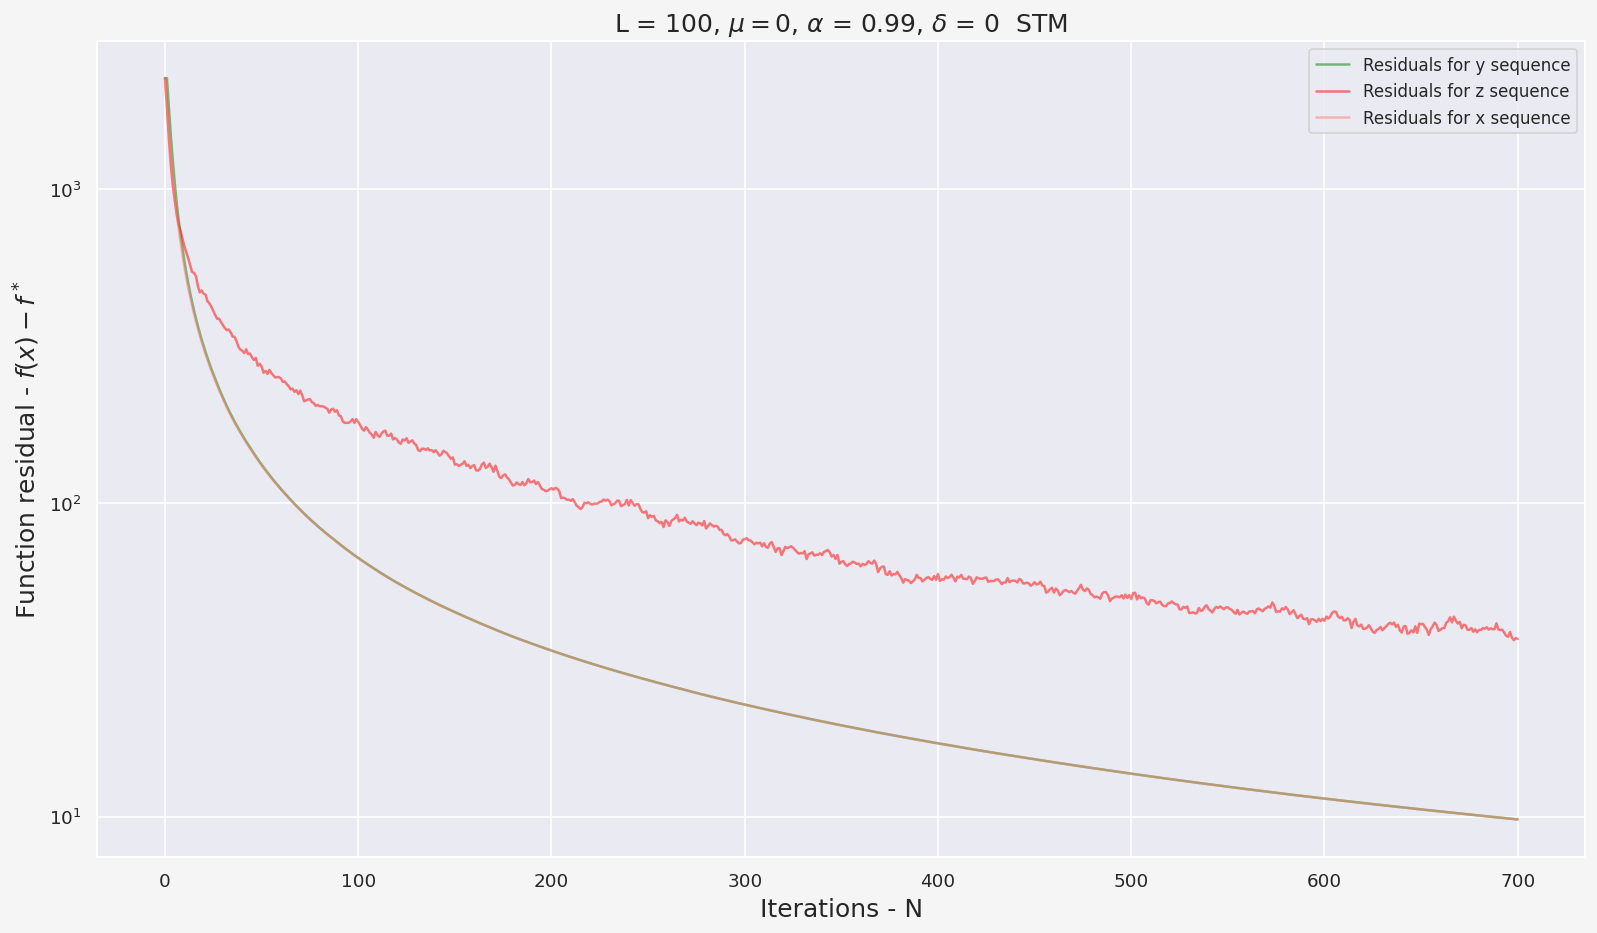

In [298]:
function = nesterov_degenerate_func(L=100)
plot_convergence(function, stm_algo, iters=700, x_start=np.ones(2000) * 10, alpha=0.99, addition_title=' STM')

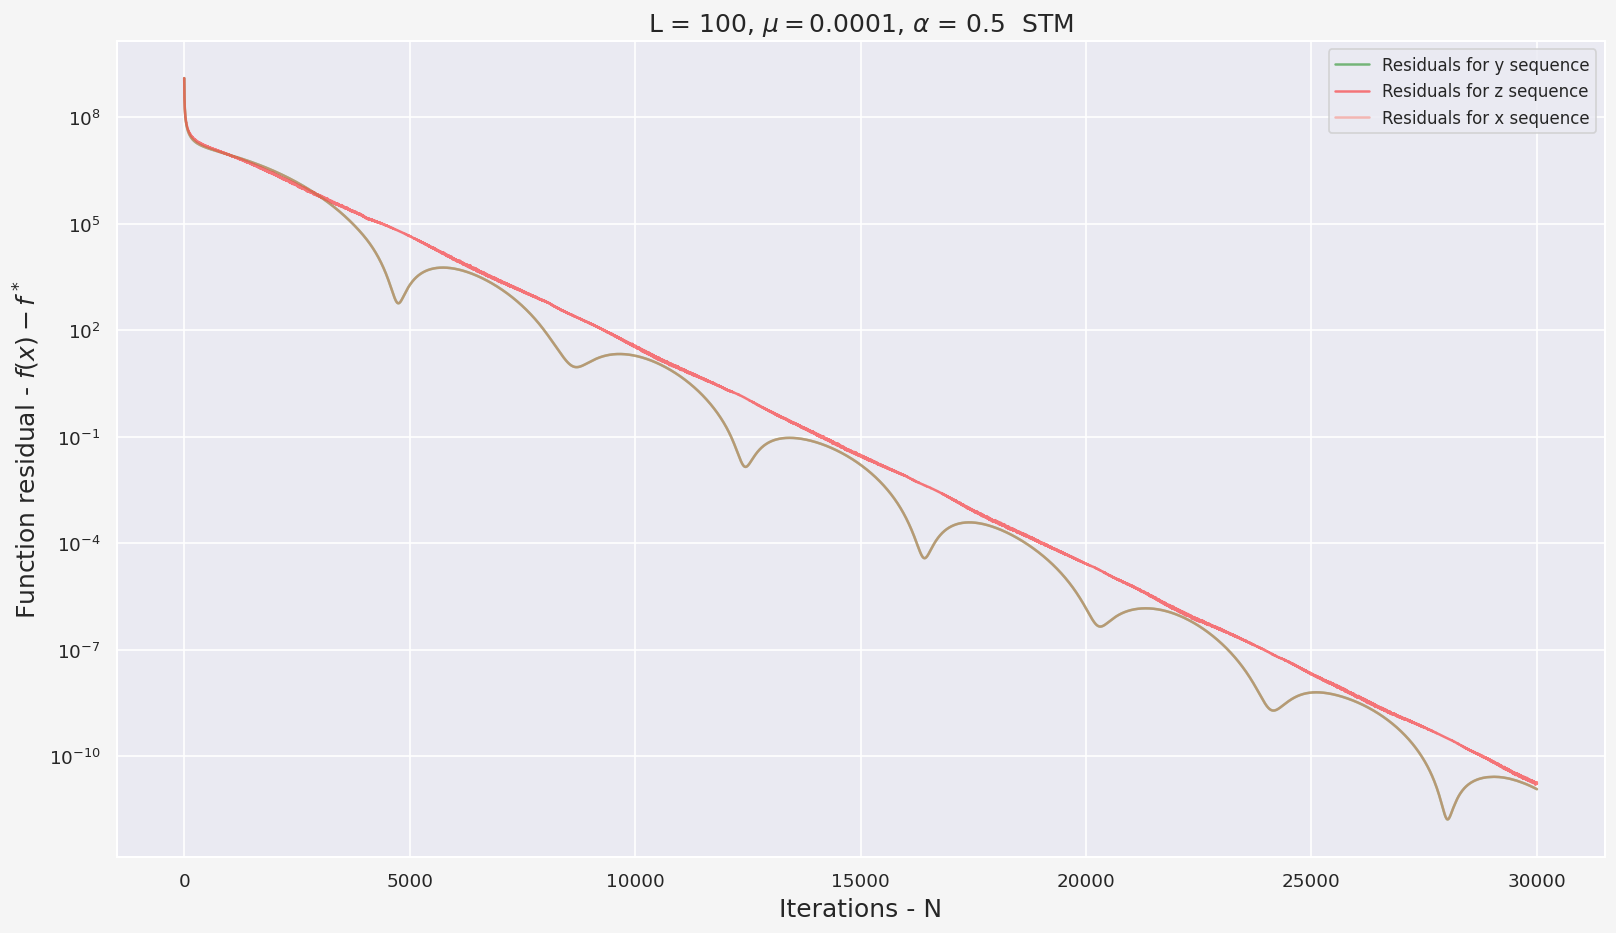

In [181]:
function = nesterov_func(100, 0.0001)
plot_convergence(function, stm_algo, iters=30000, x_start=np.ones(2000) * 10000, alpha=0.5, addition_title=' STM')

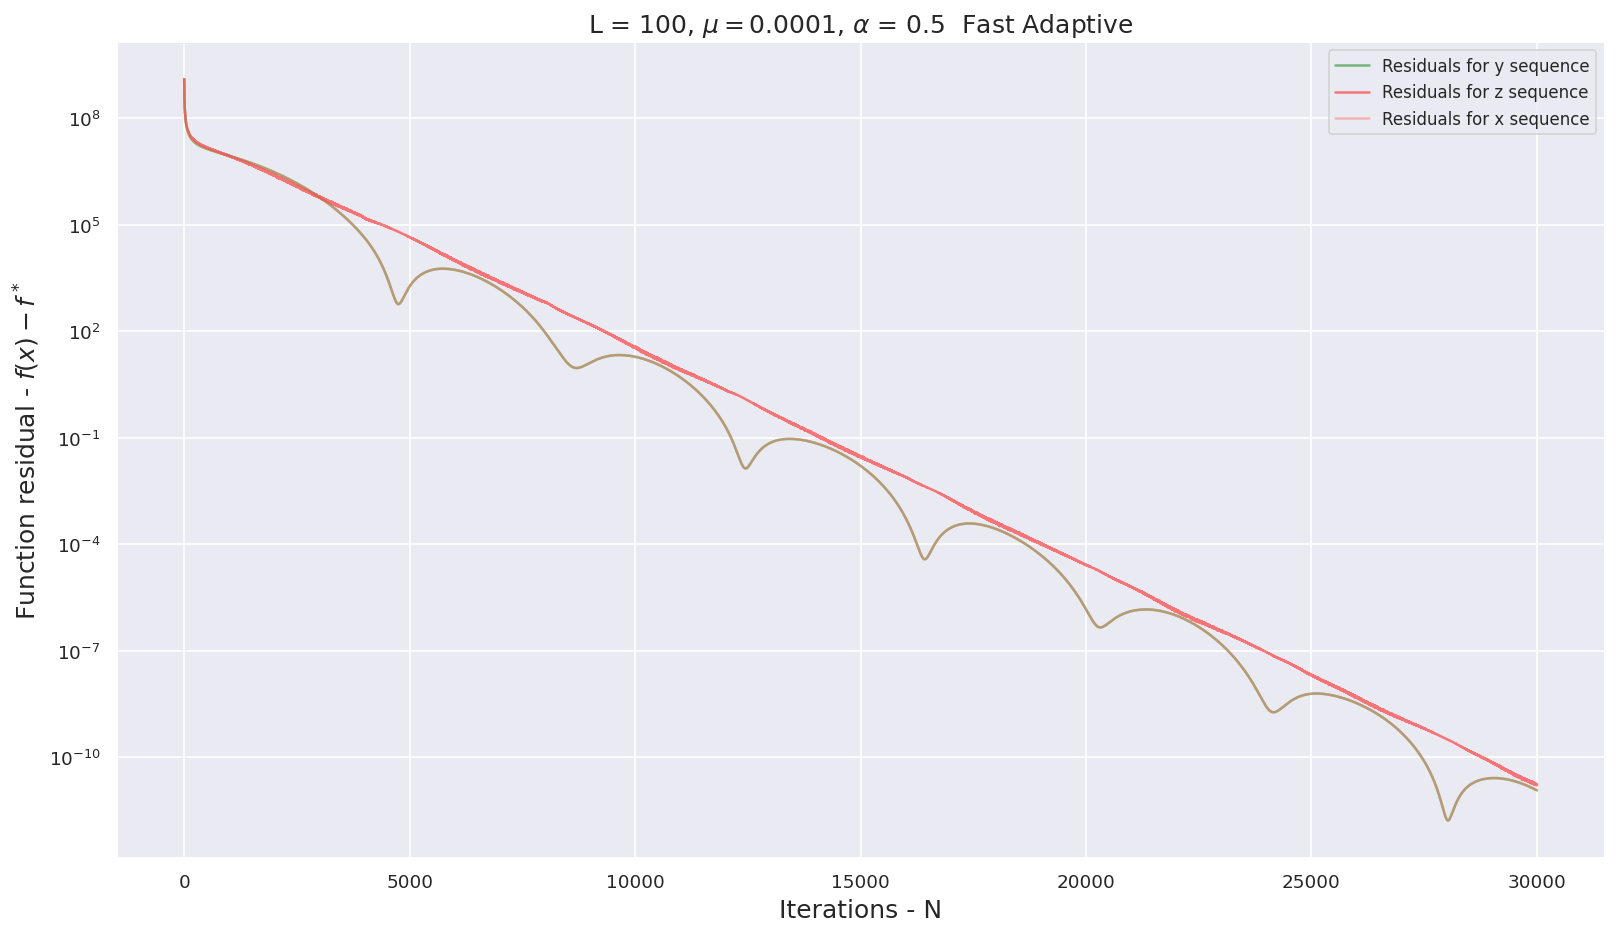

In [63]:
function = nesterov_func(100, 0.0001)
plot_convergence(function, adaptive_fast, iters=30000, x_start=np.ones(2000) * 10000, alpha=0.5, addition_title=' Fast Adaptive')

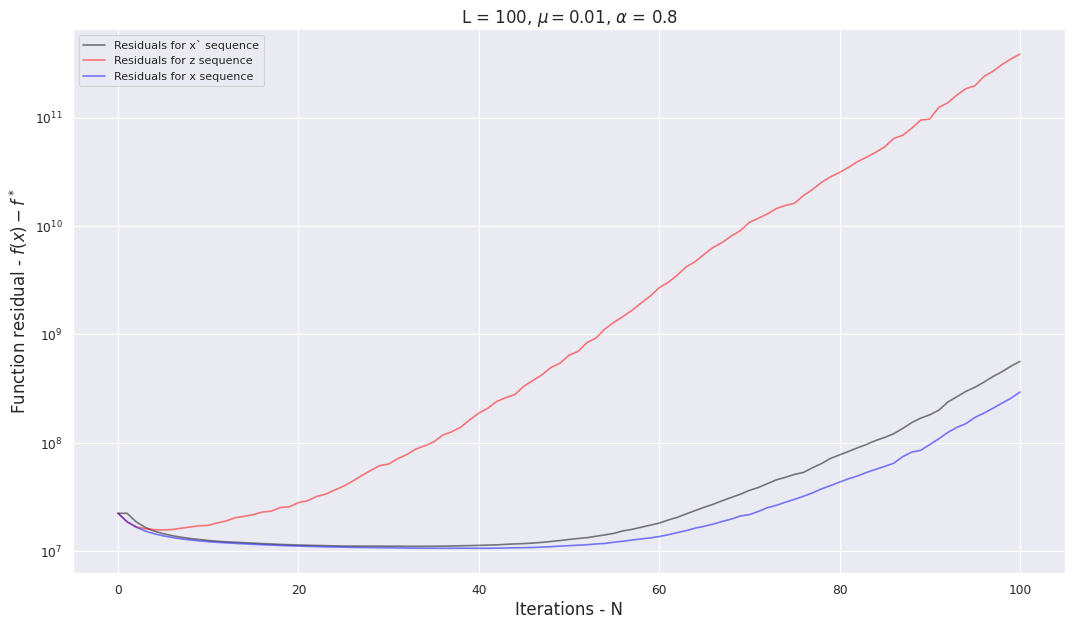

In [74]:
function = nesterov_func(100, 0.01)
plot_convergence_stm(function, iters=100, x_start=np.ones(2000) * 1000, alpha=0.80, algo=adaptive_fast)

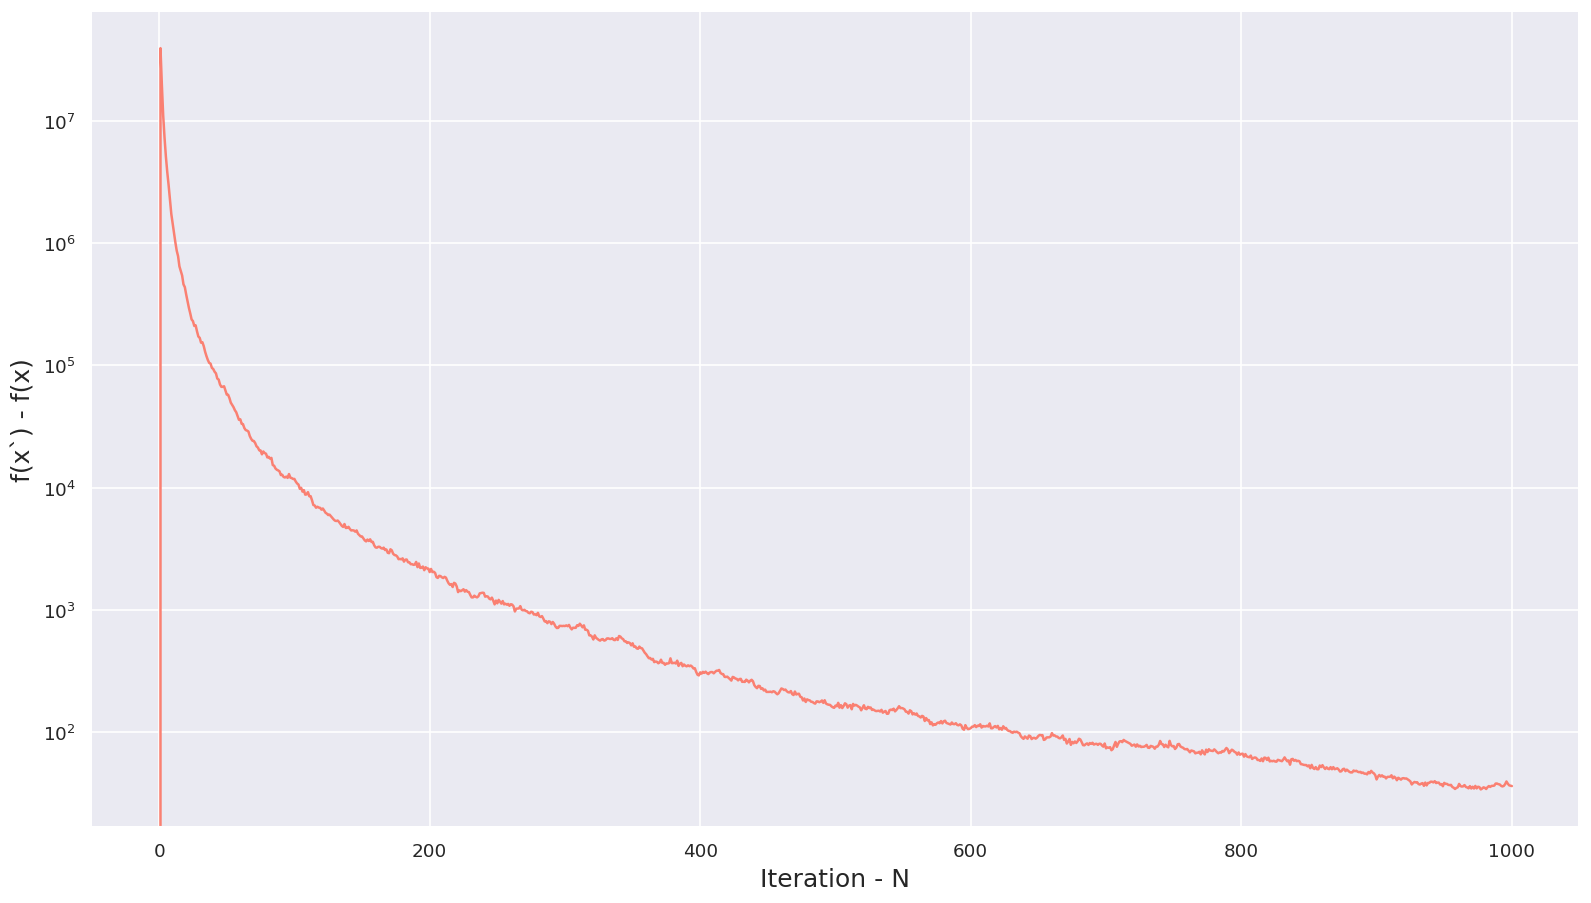

In [70]:
function = nesterov_func(1000, 0.0001)
stm_tilde_dif(function, iters=1000, x_start=np.ones(2000) * 1000, alpha=0.7, algo=adaptive_fast)

In [156]:
def plot_f(alpha : float):
    
    N = 10000
    xs = np.linspace(0, 1, N)
    p = 1 - np.sqrt(xs)
    
    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        
        plt.figure(figsize=(16, 9))
        
        th = (2 - p) * p + (2 + p) * alpha
        pp = (th + np.sqrt(th * th + 4 * alpha * p * p * (2 - p))) / (2 * (2 - p))
        
        pw = 1 - p
        
        plt.plot(pw, pp, color='red', label='Garnot convergence')
        
        plt.plot(pw, np.exp(-pw), color='blue', label=r'$e^{-\sqrt{\frac{\mu}{L}}}$')
        plt.plot(pw, np.exp(-pw * pw), color='green', label=r'$e^-{\frac{\mu}{L}}$')
        plt.xlabel(r'$\sqrt{\frac{\mu}{L}}$', fontsize=25)
        plt.legend(loc='best', fontsize=15)
        plt.title('Convergence comparison for ' + r'$\alpha = {}$'.format(alpha), fontsize=20)
        plt.show()
        
    

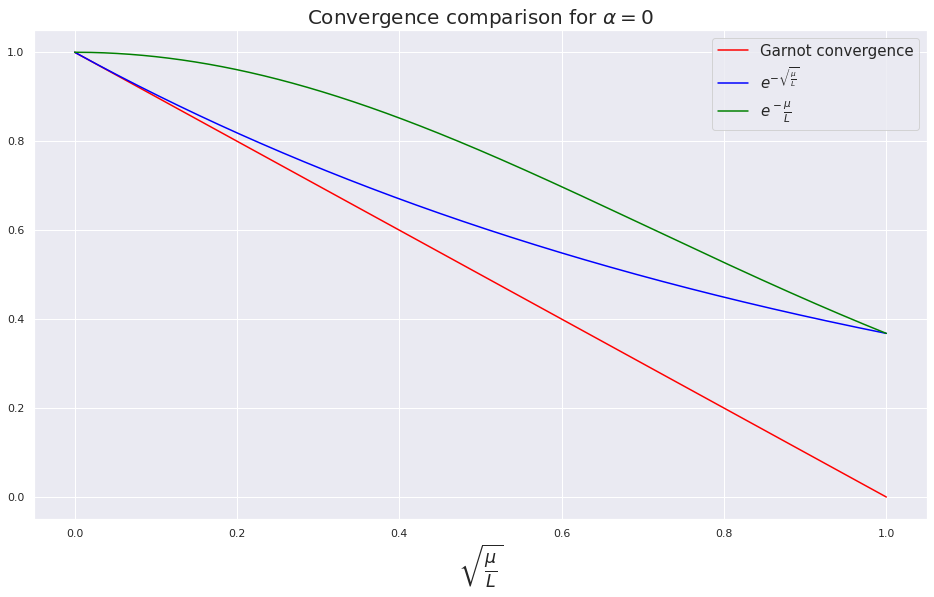

In [159]:
plot_f(0)

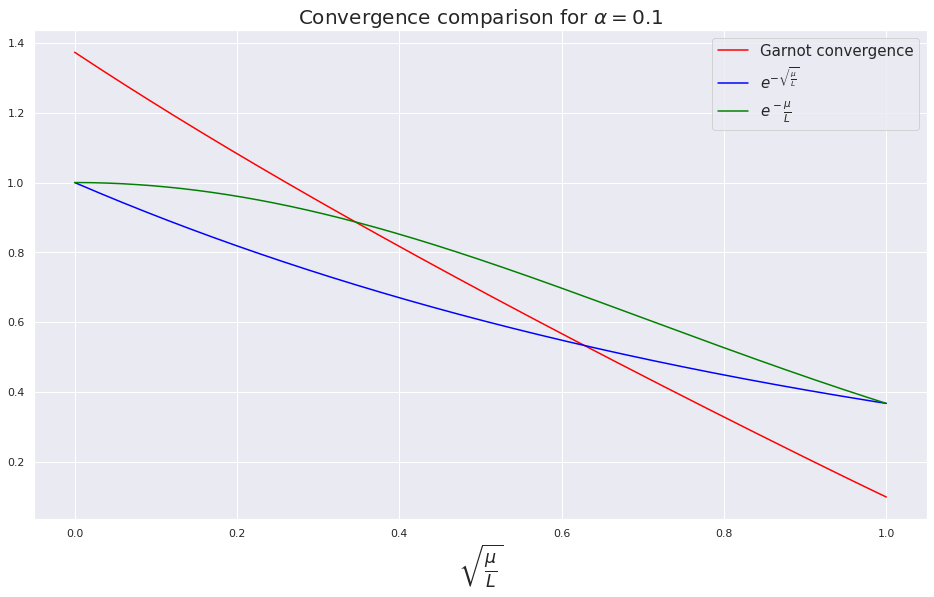

In [158]:
plot_f(0.1)

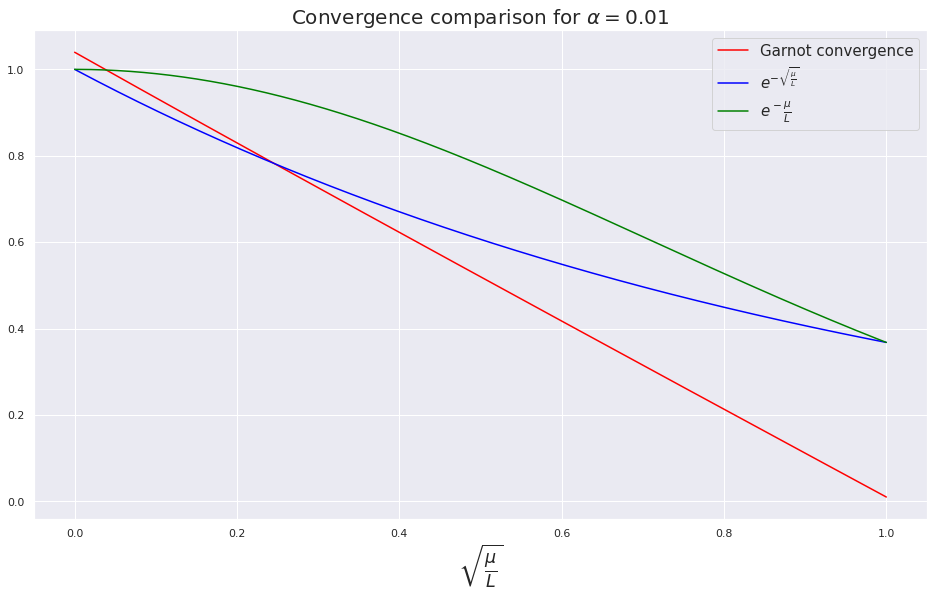

In [171]:
plot_f(0.01)

In [287]:
def find_alpha(function_opt, algo, iters : int) -> float:
    prec = 0.01
    k = 0
    left = 0
    right = 1
    d = 2000
    value = 10000
    x_start = np.ones(d) * value
    diff_0 = function_opt(x_start) - function_opt.min_value(d)
    
    print(function_opt.mu, function_opt.L)
    
    while 2 ** (-k) > prec:
        
        k += 1
        
        middle = (left + right) / 2
        path = algo(function_opt, x_start=x_start, dim=d, delta=0, alpha=middle, iters=iters, make_boost_step=False)
        diff = function_opt(path[-1][-1]) - function_opt.min_value(d)
        print(diff, diff_0)
        
        if diff > diff_0 * 1.3 or np.isnan(diff):
            right = middle
        else:
            left = middle
        
    return left


def plot_alpha_mu(mu : float):
   
    N = 10
    dig = 8
    chi_bound = 10 ** dig
    L_values = np.sort(2 * mu * np.logspace(0, dig, dig + 1))
    
    chi_values = [mu / L for L in L_values]
    
    alpha_values = [find_alpha(nesterov_func(mu=mu, L=L), stm_algo, iters=500) for L in L_values]
    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        
        plt.figure(figsize=(12, 8), dpi=120, facecolor='whitesmoke')
        plt.semilogx(chi_values, alpha_values, color='red')
        plt.xlabel(r'$\chi = \frac{\mu}{L}$', fontsize=15)
        plt.title(r'Dependence max relative noise on $\chi$, $\mu = ${}  STM'.format(mu), fontsize=15)
        plt.ylabel(r'$\alpha^*$', fontsize=15)
        plt.show()
    
    
def plot_alpha_L(L : float):
    
    dig = 7
    chi_bound = 10 ** dig
    mu_values = np.sort(L / 2 / np.logspace(0, dig, dig + 1))
    
    chi_values = [mu / L for mu in mu_values]
    
    alpha_values = [find_alpha(nesterov_func(mu=mu, L=L), stm_algo, iters=500) for mu in mu_values]
    
    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        
        plt.figure(figsize=(12, 8), dpi=120, facecolor='whitesmoke')
        plt.semilogx(chi_values, alpha_values, color='red')
        plt.xlabel(r'$\chi = \frac{\mu}{L}$', fontsize=15)
        plt.title(r'Dependence max relative noise on $\chi$, $L = ${}  STM'.format(L), fontsize=15)
        plt.ylabel(r'$\alpha^*$', fontsize=15)
        plt.show()

        
        
def plot_alpha_tripple_mu(mu : float):
    
    N = 10
    dig = 8
    chi_bound = 10 ** dig
    L_values = np.sort(2 * mu * np.logspace(0, dig, dig + 1))
    
    chi_values = [mu / L for L in L_values]
    
    alpha_values = [find_alpha(nesterov_func(mu=mu, L=L), algo_triple_momentum, iters=5000) for L in L_values]
    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        
        plt.figure(figsize=(12, 8), dpi=120, facecolor='whitesmoke')
        plt.semilogx(chi_values, alpha_values, color='red')
        plt.xlabel(r'$\chi = \frac{\mu}{L}$', fontsize=15)
        plt.title(r'Dependence max relative noise on $\chi$, $\mu = ${}  triple momentum method'.format(mu), fontsize=15)
        plt.ylabel(r'$\alpha^*$', fontsize=15)
        plt.show()


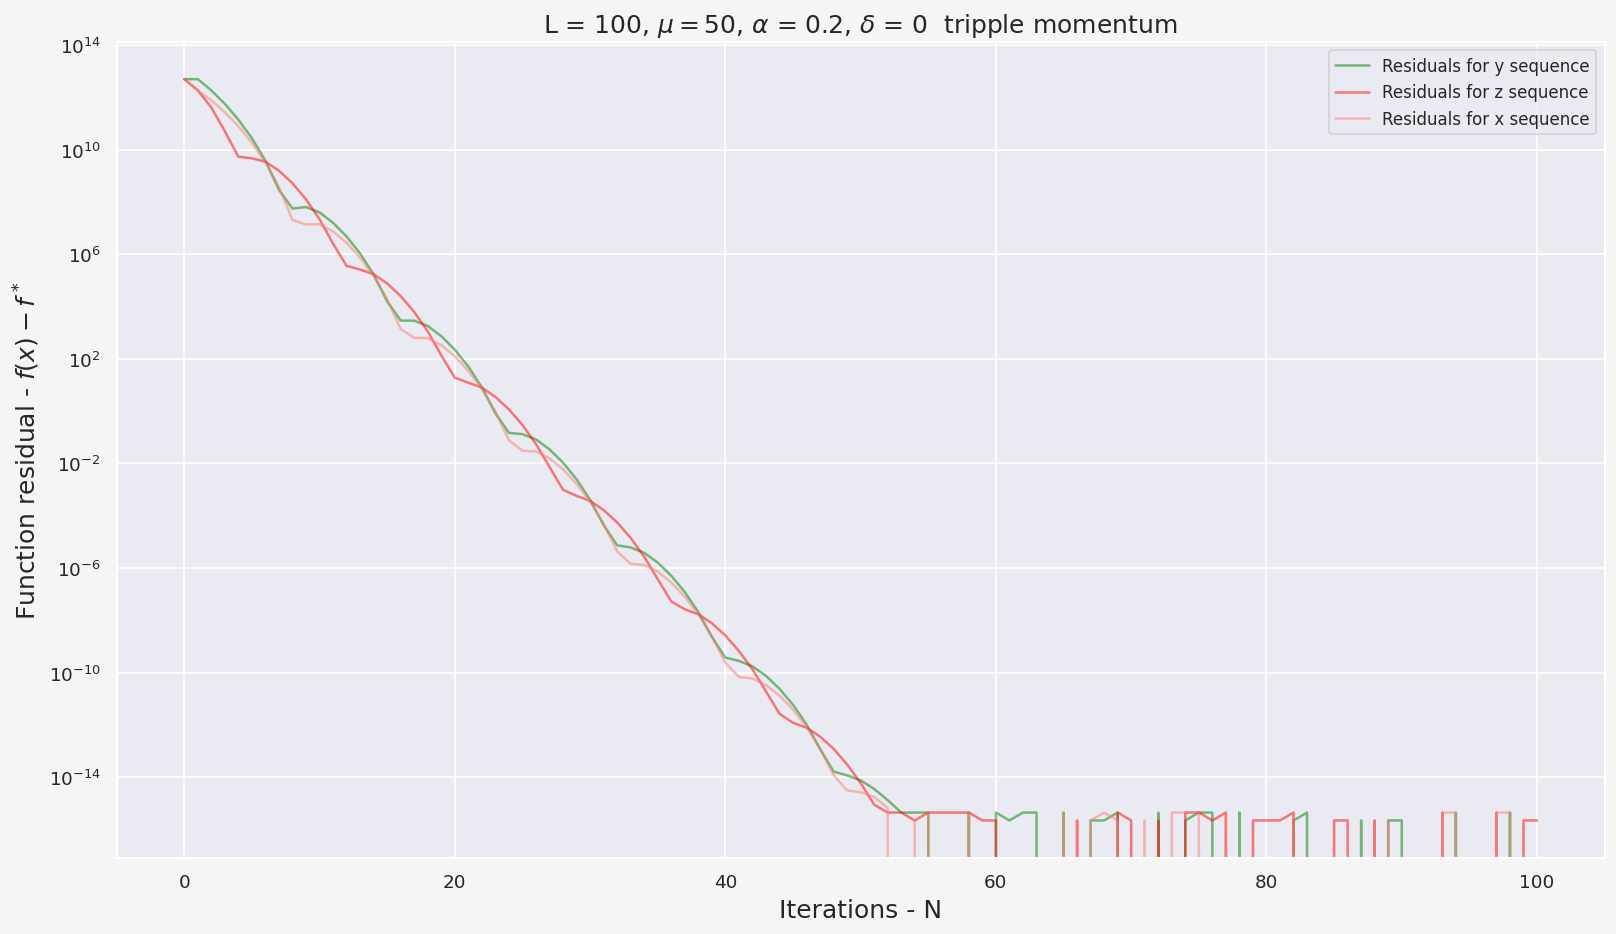

In [277]:
function = nesterov_func(100, 50)
plot_convergence(function, iters=100, x_start=np.ones(2000) * 10000, alpha=0.2, algo=stm_algo, addition_title=' tripple momentum')

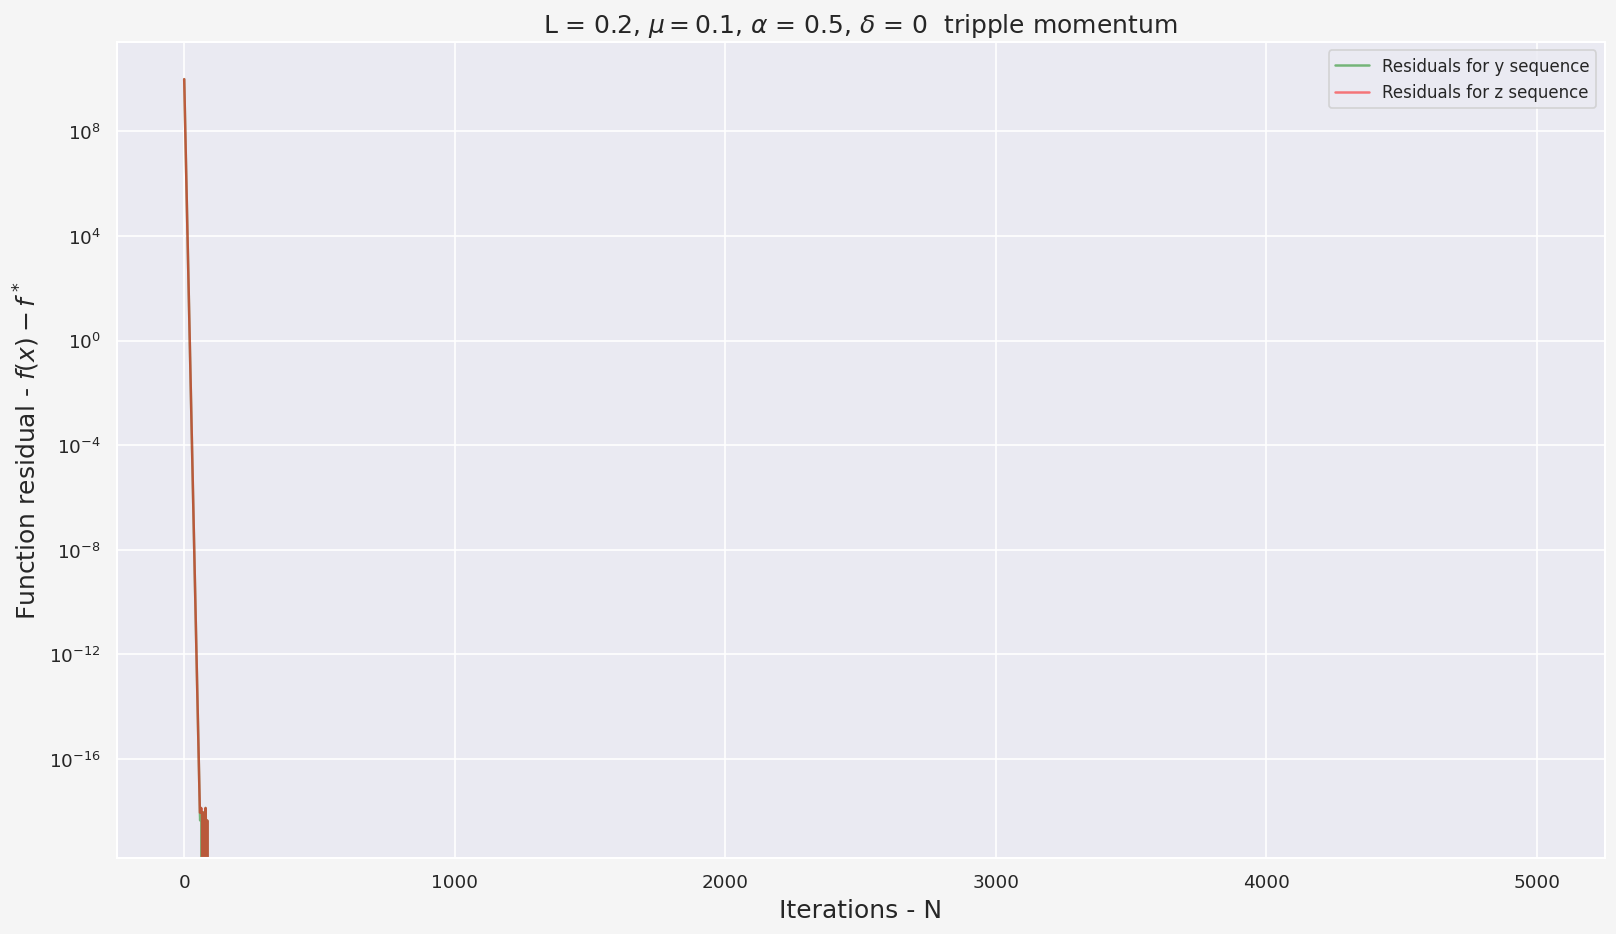

In [254]:
function = nesterov_func(0.2, 0.1)
plot_convergence(function, iters=5000, x_start=np.ones(2000) * 10000, alpha=0.5, algo=algo_triple_momentum, addition_title=' tripple momentum')

# Вывод:

Видно,что в модели аддитивного шума метод может разносить при неправильном подборе констант $\mu, L$. В модели сильной выпуклости и аддитивной неточности можно решать задачу с нужной точностью.